In [1]:
# Library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.cross_validation import cross_val_score

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Import the dataset

data = pd.read_csv("appdata10.csv")
data.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [3]:
# Summary statistics
data.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
type(data['hour'][0])

str

In [5]:
# Convert 'hour' column entries from str to int, with only first 2 numbers

data['hour'] = data['hour'].str.slice(1, 3).astype(int)

In [6]:
type(data['hour'][0])

numpy.int32

In [7]:
# Create a dataset for plotting purposes, only having numerical columns

plot_data = data.copy().drop(columns=['user', 'first_open', 'screen_list', 'enrolled_date', 'enrolled'])

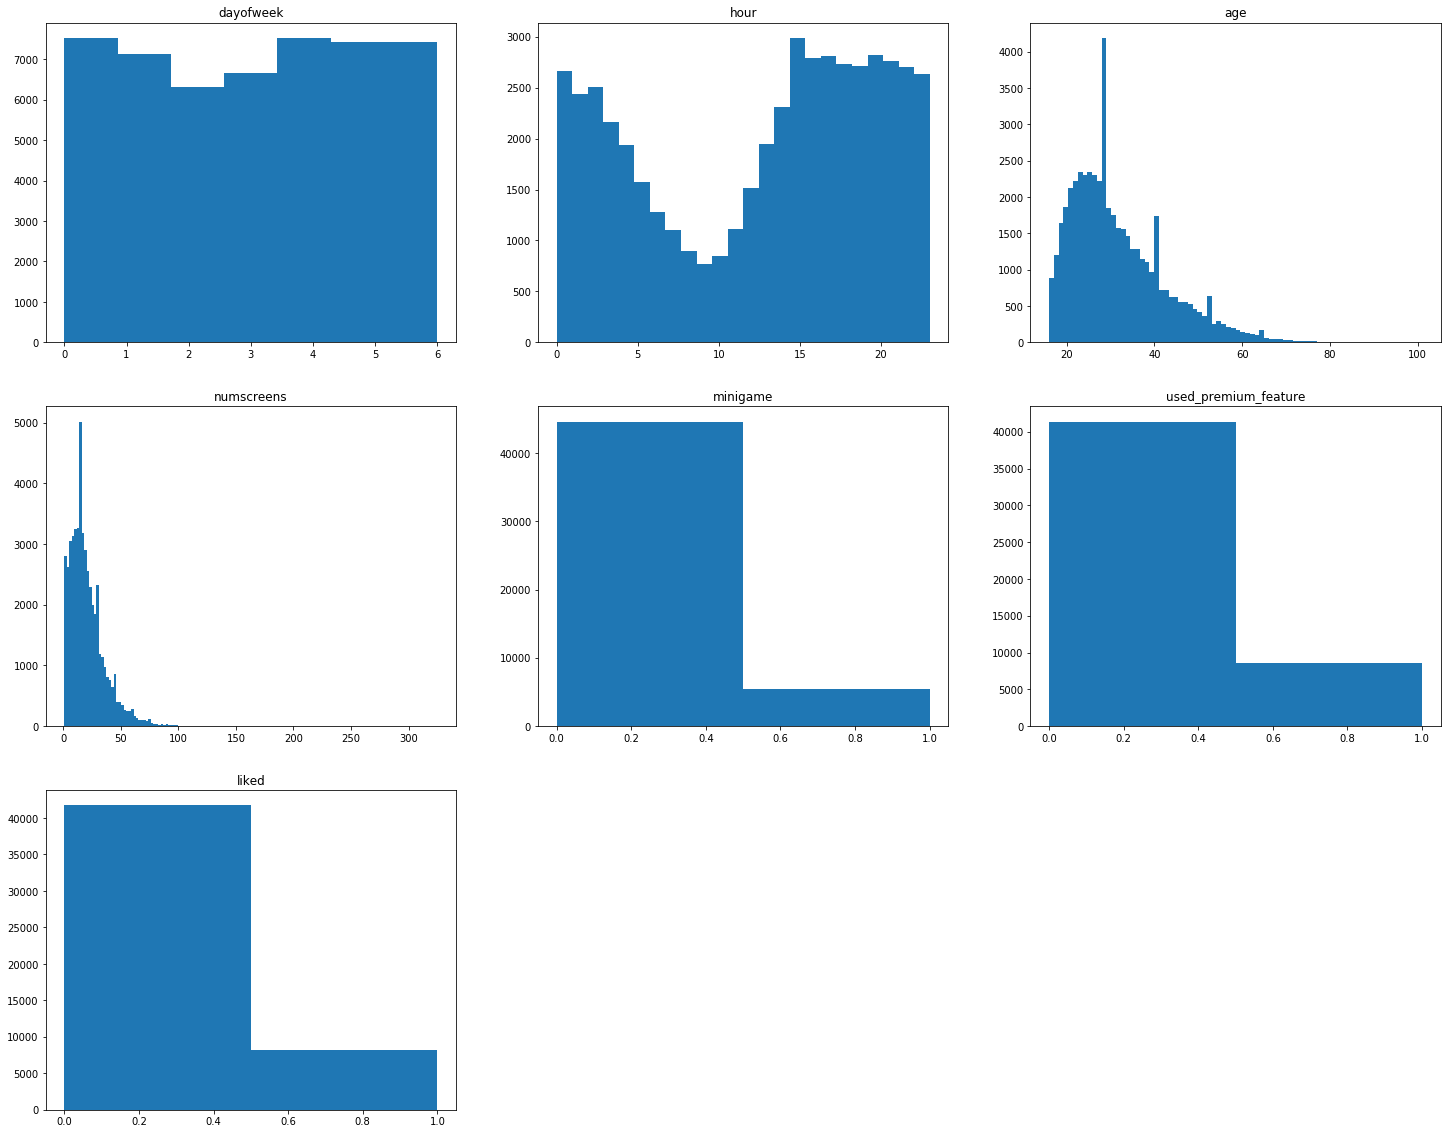

In [8]:
# Plot distributions of all numeric data

plt.figure(figsize=(25,20))
for i in range(1, plot_data.shape[1]+1):
    
    plt.subplot(3, 3, i)
    f = plt.gca()
    f.set_title(plot_data.columns.values[i-1])
    bins = np.size(plot_data.iloc[:, i-1].unique())
    plt.hist(plot_data.iloc[:, i-1], bins=bins)

1. All days of week seem to be evenly distributed. There does not seem to be a particular day being favored by app users
2. We see a dip in hour because of late night/early morning (hour is according to UTC and PST is 8 hours behind it, which makes sense)
3. Age distribution is skewed to the right, meaning more young people use the app compared to elders. Spikes around the age of about 30 and 40 indicate those ages are more likely users
4. There are 58 top screens on the app, out of which about 20-25 screens are viewed by high number of users
5. High number of people did not play the in-app minigame, did not use premium features during the free trial and also did not press the 'Like' button in the app

Text(0.5,1,'Correlation with Target variable')

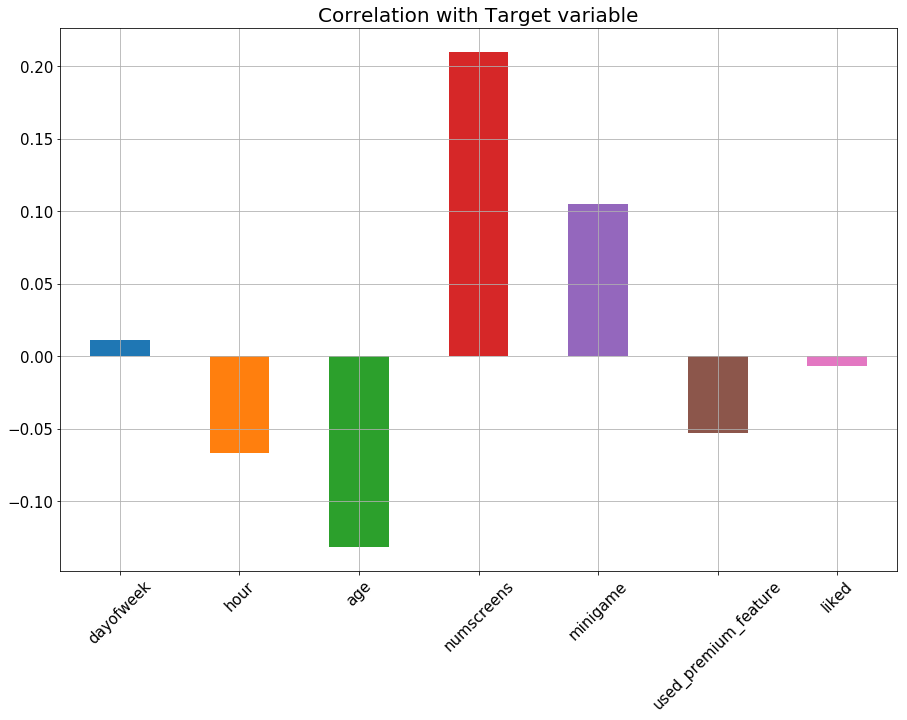

In [9]:
# Check correlation of numerical variables with target variable

plot_data.corrwith(data['enrolled']).plot.bar(figsize=(15,10), fontsize=15, rot=45, grid=True)
plt.title('Correlation with Target variable', fontsize=20)

1. Negative correlation with age - meaning older people are less likely to subscribe to the premium version, which makes sense
2. Positive correlation with numscreens - meaning people who navigated to higher number of screens are more likely to pay for subscription, which makes sense because those are engaged users
3. Positive correlation with minigame - meaning people who played the minigame were more likely to subscribe for the premium version
4. Very interestingly, used_premium_feature is negatively correlated - meaning the more a person uses premium features in the free trial, the less likely they are to subscribe to the premium version

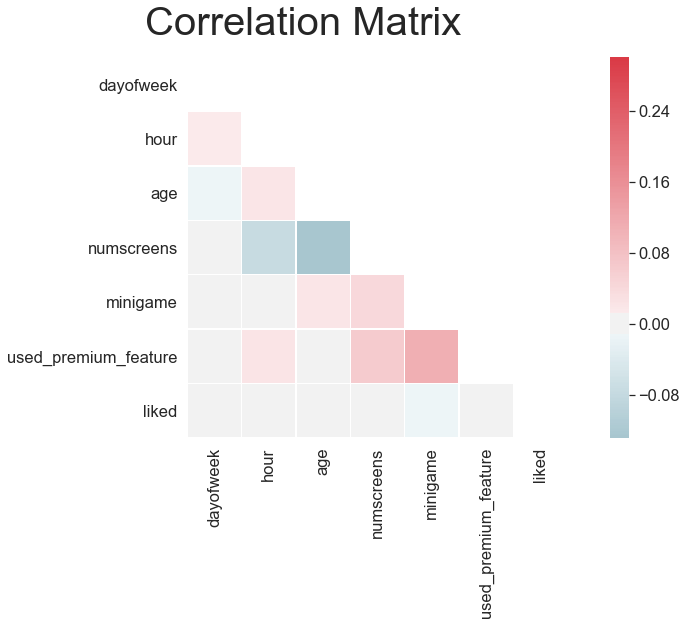

In [10]:
# Check correlations of features with each other

sns.set(style='white', font_scale=1.5)
corr = plot_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15,7))
f.suptitle('Correlation Matrix', fontsize=40)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, square=True, vmax=0.3, center=0, linewidths=0.5)

In [11]:
# Check for any dtype conversions necessary
data.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int32
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [12]:
# Convert first_open and enrolled_date into datetime objects

data['first_open'] = [parser.parse(row) for row in data['first_open']]

In [13]:
data['enrolled_date'] = [parser.parse(row) if isinstance(row, str) else row for row in data['enrolled_date']]

In [14]:
data.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int32
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

In [15]:
# Calculate the time between first_open and enrolled_date in hours

data['Difference'] = (data['enrolled_date']-data['first_open']).astype('timedelta64[h]')

Text(0.5,1,'Distribution of Hours B/W first_open and enrollment')

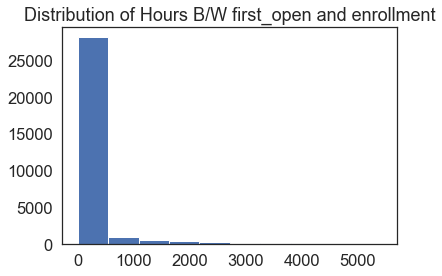

In [16]:
# Check the distribution of Difference column

plt.hist(data['Difference'].dropna())
plt.title('Distribution of Hours B/W first_open and enrollment')

Text(0.5,1,'Distribution of Hours B/W first_open and enrollment')

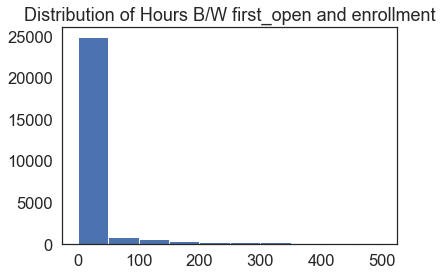

In [17]:
# Since distribution is skewed massively, plot only initial 500 values

plt.hist(data['Difference'].dropna(), range=[0, 500])
plt.title('Distribution of Hours B/W first_open and enrollment')

Text(0.5,1,'Distribution of Hours B/W first_open and enrollment')

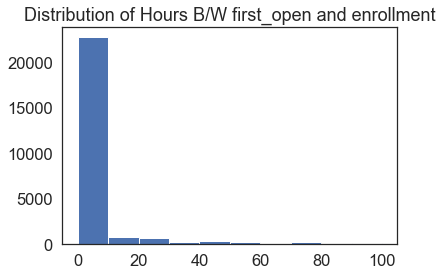

In [18]:
# Disribution is still skewed, plot only first 100 hours

plt.hist(data['Difference'].dropna(), range=[0,100])
plt.title('Distribution of Hours B/W first_open and enrollment')

In [19]:
# Consider only first 48 hours and convert rest of the responses to 0

data.loc[data['Difference'] > 48, 'enrolled'] = 0

In [20]:
# Drop unnecessary columns before modeling

data = data.drop(columns=['Difference', 'first_open', 'enrolled_date'])

In [21]:
# Read the list of top screens visited

top_screens = pd.read_csv('top_screens.csv').top_screens.values

In [22]:
# Convert the screen_list from original data into str with their respective commas

data['screen_list'] = data.screen_list.astype(str) + ","

In [23]:
# Make new binary columns for all top screens 

for screen in top_screens:
    
    data[screen] = data.screen_list.str.contains(screen).astype(int)
    data['screen_list'] = data.screen_list.str.replace(screen+",", "")

In [24]:
# Count all remaining screens into a new column

data['Other'] = data.screen_list.str.count(",")
data = data.drop(columns=['screen_list'])

In [25]:
# Remove correlation from savings screens funnel

savings_screens = ['Saving1', 'Saving2', 'Saving2Amount', 'Saving4', 'Saving5', 'Saving6', 'Saving7', 'Saving8', 
                   'Saving9', 'Saving10']
data['Savings_Count'] = data[savings_screens].sum(axis=1)
data = data.drop(columns=savings_screens)

In [26]:
# Remove Credit Monitoring funnel correlation

cm_screens = ['Credit1', 'Credit2', 'Credit3', 'Credit3Container', 'Credit3Dashboard']
data['CM_Count'] = data[cm_screens].sum(axis=1)
data = data.drop(columns=cm_screens)

In [27]:
# Remove Credit Card funnel correlation

cc_screens = ['CC1', 'CC1Category', 'CC3']
data['CC_Count'] = data[cc_screens].sum(axis=1)
data = data.drop(columns=cc_screens)

In [28]:
# Remove Loan screens funnel correlation

loan_screens = ['Loan', 'Loan2', 'Loan3', 'Loan4']
data['Loan_Count'] = data[loan_screens].sum(axis=1)
data = data.drop(columns=loan_screens)

In [29]:
# Create a separate target variable and remove it from main data

target = data['enrolled']
data = data.drop(columns='enrolled')

In [30]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)

In [31]:
# Remove user from training and test sets but store them for identification in the future

train_identifier = X_train['user']
X_train = X_train.drop(columns='user')
test_identifier = X_test['user']
X_test = X_test.drop(columns='user')

In [32]:
# Scale the features in the training and test sets

sc_X = StandardScaler()
X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train), columns=X_train.columns.values, index=X_train.index.values)

X_test_scaled = pd.DataFrame(sc_X.transform(X_test), columns=X_test.columns.values, index=X_test.index.values)

In [33]:
# Store scaled values into original training and test sets

X_train = X_train_scaled
X_test = X_test_scaled

In [34]:
# Fit the model with L1 regularization to avoid collinearity in screens

classifier = LogisticRegression(random_state=0, penalty='l1')
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Text(0.5,1,'Confusion Matrix')

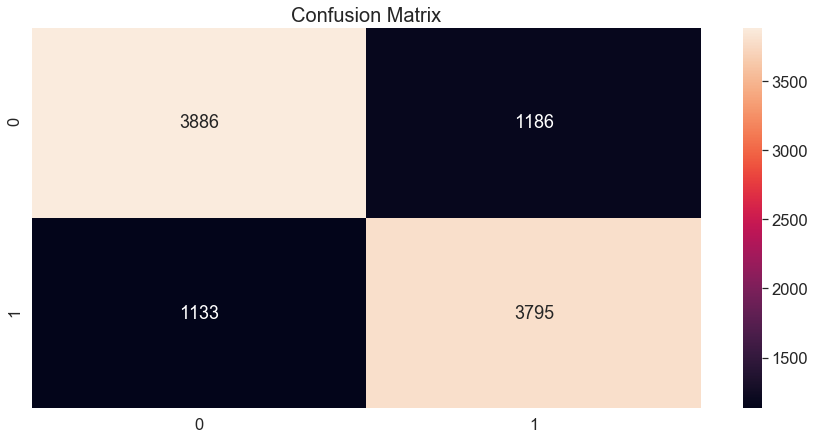

In [35]:
# Get predictions on test set and measure various accuracy scores

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])
plt.figure(figsize=(15,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion Matrix", fontsize=20)

In [36]:
print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))

Precision: 0.7619
Recall: 0.7701
F1 Score: 0.7660
Accuracy: 0.7681


In [37]:
# Perform 10 fold cross validation to estimate generalization error (should be close to test accuracy)

scores = cross_val_score(classifier, X_train, y_train, cv=10)

In [38]:
print("CV Accuracy: {:.4f} +/- {:.4f}".format(scores.mean(), scores.std()*2))

CV Accuracy: 0.7672 +/- 0.0096


In [39]:
# Append result to the test set

result = pd.concat([y_test, test_identifier], axis=1)
result['Prediction'] = y_pred
result[['user', 'enrolled', 'Prediction']].reset_index(drop=True)

,user,enrolled,Prediction
0,239786,1,1
1,279644,1,1
2,98290,0,0
3,170150,1,1
4,237568,1,1
5,65042,1,0
6,207226,1,1
7,363062,0,0
8,152296,1,1
9,64484,0,0
